In [15]:
import pandas as pd
import os
import json
from  builtins import any as b_any
from csv import writer
import matplotlib.pyplot as plt

## Eurotopics data

In [2]:
eurotopics_data = pd.read_excel(r'/homenfs/l.bellomo1/EU-NewsDataset/mappings/Eurotopics_media_label.xls', index_col=0) 

#### Exploring included EU countries
- selecting only EU countries (and UK) among the avaiable countries

In [3]:
# all countries 
eurotopics_data['Country'].unique()

array(['Egypt', 'Algeria', 'Argentina', 'Australia', 'Belarus', 'Belgium',
       'Benin', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'China', 'Germany', 'Denmark', 'Estonia',
       'Finland', 'France', 'Greece', 'United Kingdom', 'Iraq', 'Ireland',
       'Israel', 'Italy', 'Jordan', 'Canada', 'Qatar', 'Colombia',
       'Croatia', 'Latvia', 'Lebanon', 'Liechtenstein', 'Lithuania',
       'Luxembourg', 'Malta', 'Morocco', 'Mexico', 'Montenegro',
       'Netherlands', 'Nigeria', 'North Macedonia', 'Austria',
       'Palestinian territories', 'Poland', 'Portugal', 'Romania',
       'Russia', 'Saudi Arabia', 'Sweden', 'Switzerland', 'Serbia',
       'Slovakia', 'Slovenia', 'Spain', 'South Korea', 'Czech Republic',
       'Turkey', 'U.S.', 'Ukraine', 'Hungary', 'Cyprus'], dtype=object)

In [4]:
# selecting only EU countries
eu_countries = ['Austria','Belgium','Bulgaria', 'Croatia','Czech Republic', 'Cyprus','Denmark','Estonia','Finland', 'France', 'Greece', 'Germany',  'Hungary','Ireland', 'Italy',  'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands','Poland', 'Portugal', 'Romania', 'Sweden', 'Slovakia', 'Slovenia', 'Spain', 'United Kingdom']
# filtering out not european countries
european_media = eurotopics_data.loc[eurotopics_data.Country.isin(eu_countries)]

In [5]:
# number of media for each european country
european_media.Country.value_counts()

Hungary           47
France            45
Greece            45
Germany           39
Romania           34
United Kingdom    31
Spain             27
Poland            26
Finland           24
Portugal          23
Bulgaria          20
Lithuania         18
Belgium           16
Czech Republic    16
Italy             16
Sweden            15
Austria           15
Latvia            13
Croatia           13
Estonia           13
Slovenia          12
Cyprus            12
Netherlands       12
Slovakia          10
Ireland           10
Denmark           10
Luxembourg         6
Malta              4
Name: Country, dtype: int64

#### Exploring avaiable Frequency of Pubblication of medias
- discarding medias that have a frequency of pubblication equal to ['Monthly','Updated on an irregular basis','Every two months','nan'] to avoid noise in the dataset

In [6]:
european_media['Frequency of publication'].unique()

array(['several times a week', 'Monday to Saturday',
       'Weekly on Wednesdays', 'Daily', 'Weekly on Thursdays',
       'Updated on an irregular basis', nan, 'Monday to Friday',
       'Weekly on Fridays', 'Weekly on Saturdays', 'Monthly',
       'Weekly on Sundays', 'Weekly on Mondays', 'several times a month',
       'Every two months', 'Weekly on Tuesdays', 'weekly'], dtype=object)

In [7]:
european_media = european_media.loc[~european_media['Frequency of publication'].isin(['Monthly','Updated on an irregular basis','Every two months','nan'])]
european_media['Frequency of publication'].value_counts()

Daily                    212
Monday to Saturday        86
several times a week      46
Monday to Friday          34
Weekly on Thursdays       30
Weekly on Fridays         29
Weekly on Sundays         17
Weekly on Wednesdays      13
Weekly on Mondays         11
Weekly on Saturdays        8
several times a month      6
Weekly on Tuesdays         1
weekly                     1
Name: Frequency of publication, dtype: int64

#### Exploring avaiable Area of Distribution of medias
- selecting only medias that have a nationwide Area of Distribution 

In [8]:
european_media['Area of distribution'].unique()

array(['Nationwide', 'Regional', nan], dtype=object)

In [9]:
european_media = european_media.loc[european_media['Area of distribution'] == 'Nationwide']
european_media['Area of distribution'].value_counts()

Nationwide    435
Name: Area of distribution, dtype: int64

#### Exploring avaiable Political Leanings of medias
- selecting only medias that have a not null political leaning and also those that are equal to ['Critical of the government','Pro-government ','Christian','Catholic', 'nationalistisch'] since they are too specific

In [10]:
european_media['Political orientation'].unique()

array(['Centre-left', 'Liberal', 'Left-wing', nan, 'Liberal-conservative',
       'Conservative', 'Critical of the government', 'Pro-government',
       'Christian', 'Right-wing', 'Far left', 'Catholic',
       'nationalistisch'], dtype=object)

In [11]:
# european media which have a political orientation and have a Frequency of publication daily or weekly and Area of distribution = nationwide (not regionally)
european_media = european_media.loc[(european_media['Political orientation'].notnull())  & (~european_media['Political orientation'].isin(['Critical of the government','Pro-government','Christian','Catholic', 'nationalistisch']))]
european_media['Political orientation'].value_counts()

Liberal                 115
Centre-left              69
Conservative             54
Liberal-conservative     41
Left-wing                37
Right-wing               11
Far left                  1
Name: Political orientation, dtype: int64

## Common Crawl Dataset

#### plot utilities

In [2]:
def plot_year_distribution(df):
    
    plt.rcParams["figure.figsize"] = (25,10)
    ax = df.groupby('year')['source_name'].count().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('# articles (millions)', fontsize = 26)
    plt.xlabel('Year', fontsize = 26)                                                                                                                                                                                                                                                                                                      

    rects = ax.patches

    # Make some labels.
    labels = ["label%d" % i for i in range(len(rects))]

    for rect in rects:
        height = rect.get_height()
        label_text = f'{int(height)}'
        ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label_text,
                ha='center', va='bottom', fontsize=20)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/n_articles_year_newdf.png')
    plt.show()

In [3]:
def plot_country_media_distribution(df):

    plt.rcParams["figure.figsize"] = (25,10)
    ax = df.groupby(['country','political_leaning'])['source_name'].nunique().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylabel('# media outlet', fontsize = 26)
    plt.xlabel('Country', fontsize = 26)
    plt.legend(prop={'size': 20}, framealpha=0.2, loc='upper left')

    for rect in ax.patches:
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()
        
        # The height of the bar is the data value and can be used as the label
        label_text = f'{int(height)}'  # f'{height:.2f}' to format decimal values

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2

        # plot only when height is greater than specified value
        if height > 0:
            ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=20, color='black')
    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/n_media_country_newdf.png')
    plt.show()

In [4]:
def plot_country_articles_distribution(df):

    plt.rcParams["figure.figsize"] = (25,10)
    ax = df.groupby(['country','political_leaning'])['source_name'].count().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('# articles (millions)', fontsize = 20)
    plt.xlabel('Country', fontsize = 20)
    plt.legend(prop={'size': 14}, framealpha=0.2, loc='upper left')

    plt.tight_layout()
    #plt.savefig('/home/morini/mydata/ebu_project/eurotopics_data/articles_country_newattempt.png')
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/n_articles_country_newdf.png')
    plt.show()

In [5]:
def plot_domain_articles_distribution(df):

    plt.rcParams["figure.figsize"] = (40,10)
    ax = df.groupby(['source_name','political_leaning'])['source_name'].count().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('# articles (millions)', fontsize = 20)
    plt.xlabel('Media Outlet', fontsize = 20)
    plt.legend(prop={'size': 14}, framealpha=0.2, loc='upper left')

    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/media_outlet_political_leaning_newdf.png')
    plt.show()

In [6]:
def plot_country_media_sources(df): # TODO: I'm not able to plot figure in subplots they remain empty

    countries = list(df.country.unique())
    n_col, n_row = 4, len(countries) // 4
    
    lenght_per_fig, height_per_fig = 10, 30
    fig, ax = plt.subplots(n_row, n_col, figsize=(lenght_per_fig*n_row, height_per_fig*n_col))
    color_map = {
        'Centre-left': 'tab:blue',
        'Liberal': 'tab:red',
        'Conservative': 'tab:orange',
        'Left-wing': 'tab:green',
        'Right-wing': 'tab:brown',
        'Liberal-conservative' : 'tab:purple'
    }

    for i, country in enumerate(countries):
        row = i // n_col
        col = i % n_col 
        tmp = pd.DataFrame(all_data.loc[all_data['country'] == country].groupby(['source_name','political_leaning'])['source_name'].count().unstack())
        tmp = tmp.fillna(0)
        labels = list(tmp.index)
        for political_leaning in list(tmp.columns):
            ax[row, col].bar(labels, tmp[political_leaning].values, label=political_leaning, color=[color_map[political_leaning]])

        ax[row, col].set_title(country, size=40)
        ax[row, col].set_ylabel('# articles (millions)', size=25) 
        ax[row, col].set_xlabel('Media Outlet', size=25) 
        ax[row, col].xaxis.set_tick_params(labelsize=25, rotation=90) 
        ax[row, col].yaxis.set_tick_params(labelsize=25) 
        ax[row, col].legend(prop={"size":20})
        

    fig.tight_layout(pad=1)
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/country_media_newdf.png')
    fig.show()

In [7]:
def plot_domain_articles_year_distribution(df):

    plt.rcParams["figure.figsize"] = (50,20)
    ax = df.groupby(['source_name','year'])['source_name'].count().unstack().plot(kind='bar', stacked=True)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylabel('# articles (millions)', fontsize = 20)
    plt.xlabel('Media Outlet', fontsize = 20)
    plt.legend(prop={'size': 14}, framealpha=0.2, loc='upper left')

    plt.tight_layout()
    plt.savefig('/homenfs/l.bellomo1/EU-NewsDataset/img/media_outlet_year_newdf.png')
    plt.show()

#### ALL EU DATA: dataset creation and analysis

TODO: generate this description once again appena abbiamo i due dataset uniti 

This dataset contains all articles extracted on common crawls and was obtained by merging 'merged.csv' and 'attempt_2020_dataset.csv'. It will be used to build the training set, the test set biased, the test set non biased
- we have the original dataset (not cleaned) /all_data_eu.csv
- the cleaned dataset was obtained running text_cleaning.py 
- from 2016 to 2021
- 192 media outlets
- 28 countries (27 EU + United Kingdom)
- we drop all nan values
- we plot various type of distribution
- we noticed that some media have the same name, so we decided to remove it to avoid confusion: duplicated_media = ['Deutsche Welle', 'The Herald', 'Delfi', 'Diena', 'Capital','Fokus', 'Kurir', 'Dnevnik', 'ABC', 'Público', 'Metro','Kathimerini', 'Politis']

In [8]:
# mappings
import json

with open('/homenfs/l.bellomo1/EU-NewsDataset/mappings/name2country.json') as json_file:
    name2country = json.load(json_file)

with open('/homenfs/l.bellomo1/EU-NewsDataset/mappings/url2name.json') as json_file:
    url2name = json.load(json_file)

with open('/homenfs/l.bellomo1/EU-NewsDataset/mappings/url2leaning.json') as json_file:
    url2leaning = json.load(json_file)

In [78]:
# uniforming links
'''
diz_names = dict()
for url,name in url2leaning.items():
    diz_names[url] = name
    if 'www' in url:
        diz_names[url.replace('www.','')] = name
    else:
        diz_names['www.'+url] = name

with open('/homenfs/l.bellomo1/EU-NewsDataset/mappings/url2leaning.json', 'w') as f:
    json.dump(diz_names, f)
'''

In [9]:
all_data = pd.read_csv('/homenfs/l.bellomo1/EUNewsArticles.csv') # opening the cleaned file for defining tess sets and training set
#all_data = all_data.loc[all_data.year.isin([2016,2017,2018,2019,2020,2021])]
all_data['year'] = all_data['date_publish'].str.split('-').str[0]
all_data = all_data.loc[all_data.year.isin(['2016','2017','2018','2019','2020','2021'])]
duplicated_media = ['Deutsche Welle', 'The Herald', 'Delfi', 'Diena', 'Capital',
       'Fokus', 'Kurir', 'Dnevnik', 'ABC', 'Público', 'Metro',
       'Kathimerini', 'Politis']
#all_data = all_data.loc[~all_data.source_name.isin(duplicated_media)]
print('# articles', len(all_data))

# articles 13385890


In [10]:
# cleaning
all_data = all_data.loc[all_data.title.notnull()]
all_data = all_data.loc[all_data.maintext.notnull()]
print('# articles', len(all_data))
all_data['political_leaning'] = all_data['source_domain'].map(url2leaning)
print(all_data.isna().sum())
all_data['source_name'] = all_data['source_domain'].map(url2name)
print(all_data.isna().sum())
all_data['country'] = all_data['source_name'].map(name2country)
print(all_data.isna().sum())
all_data = all_data.drop('leaning', 1)
all_data = all_data.loc[all_data.political_leaning.isin(['Conservative', 'Liberal', 'Centre-left', 'Right-wing',
       'Left-wing', 'Liberal-conservative'])]
print('# articles', len(all_data))

# articles 11692357


In [16]:
all_data.year.value_counts()

2019    4220929
2018    3407151
2017    2162966
2020    1166237
2016     369536
2021     365538
Name: year, dtype: int64

In [21]:
all_data.political_leaning.value_counts()

Conservative            4179060
Liberal                 2232150
Centre-left             2216710
Liberal-conservative    1104390
Right-wing              1031531
Left-wing                928511
Name: political_leaning, dtype: int64

In [22]:
print('# media outlets', all_data.source_name.nunique())
print('# country', all_data.country.nunique())
print('country', all_data.country.unique())

# media outlets 211
# country 29
country ['Romania' 'Ireland' 'Croatia' 'Greece' 'Hungary' 'France'
 'United Kingdom' 'Portugal' 'Germany' 'Sweden' 'Belgium' 'Italy' 'Spain'
 'Lithuania' 'Latvia' 'Austria' 'Cyprus' 'Estonia' 'Slovenia'
 'Netherlands' 'Czech Republic' 'Bulgaria' 'Finland' 'Poland' 'Denmark'
 'Slovakia' 'U.S.' 'Malta' 'Luxembourg']


In [23]:
all_data.isna().sum()

id                      0
date_publish            0
maintext                0
title                   0
source_domain           0
url                     0
language             1835
year                    0
political_leaning       0
source_name             0
country                 0
dtype: int64

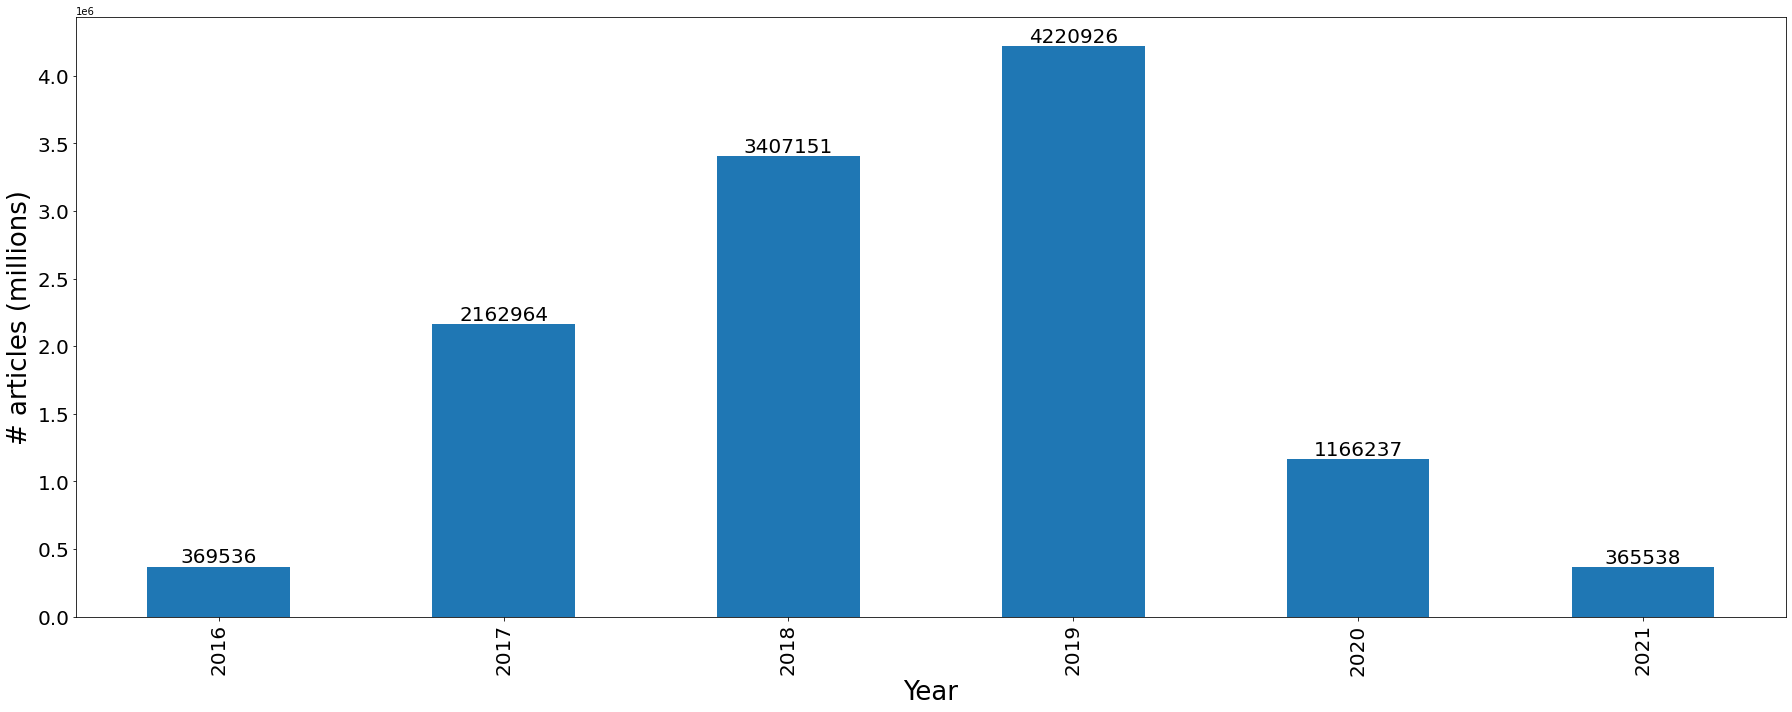

In [24]:
plot_year_distribution(all_data)

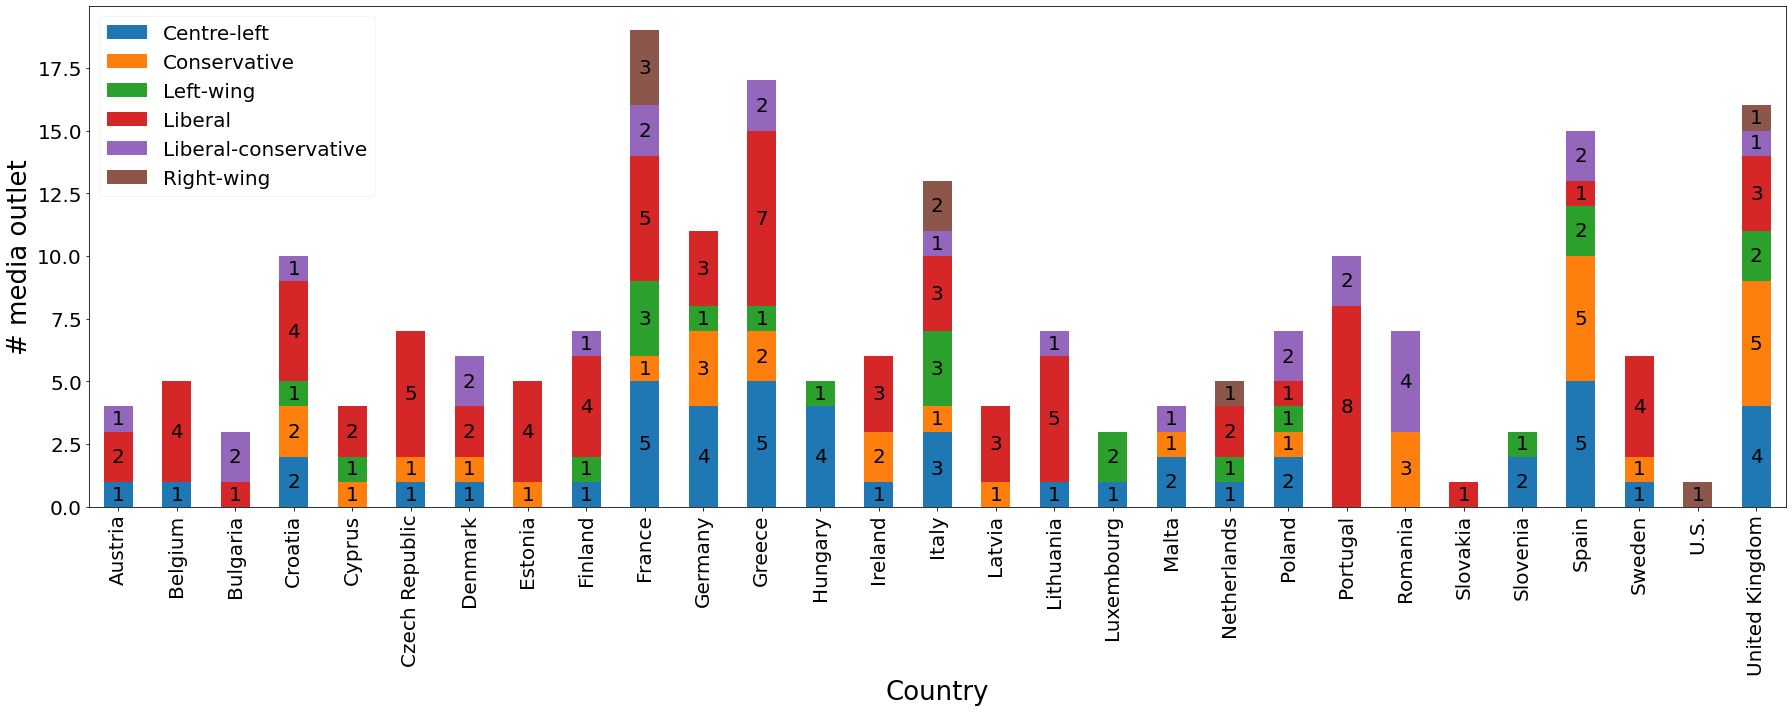

In [25]:
plot_country_media_distribution(all_data)

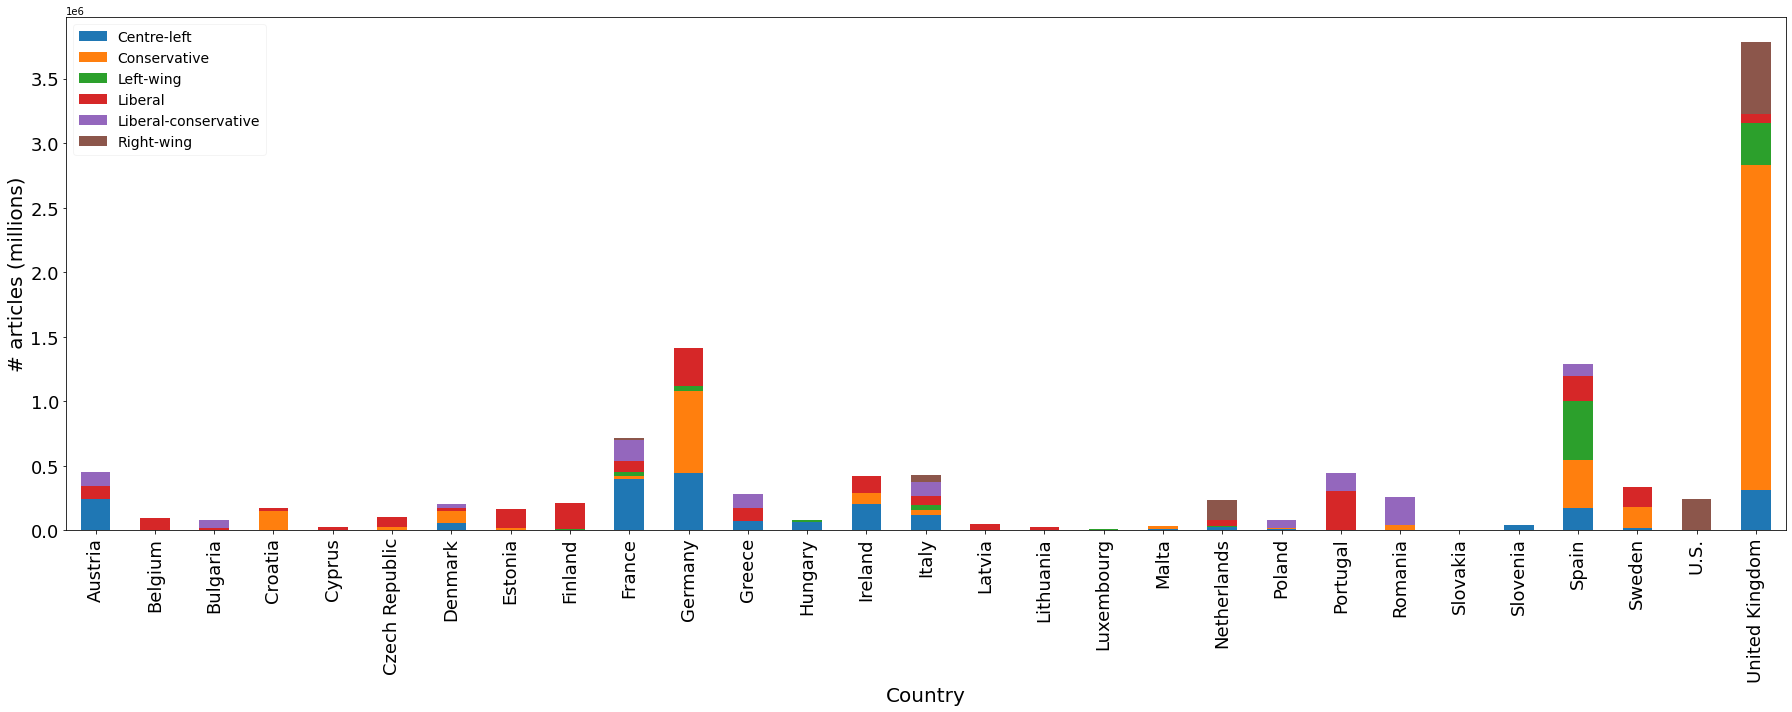

In [26]:
plot_country_articles_distribution(all_data)

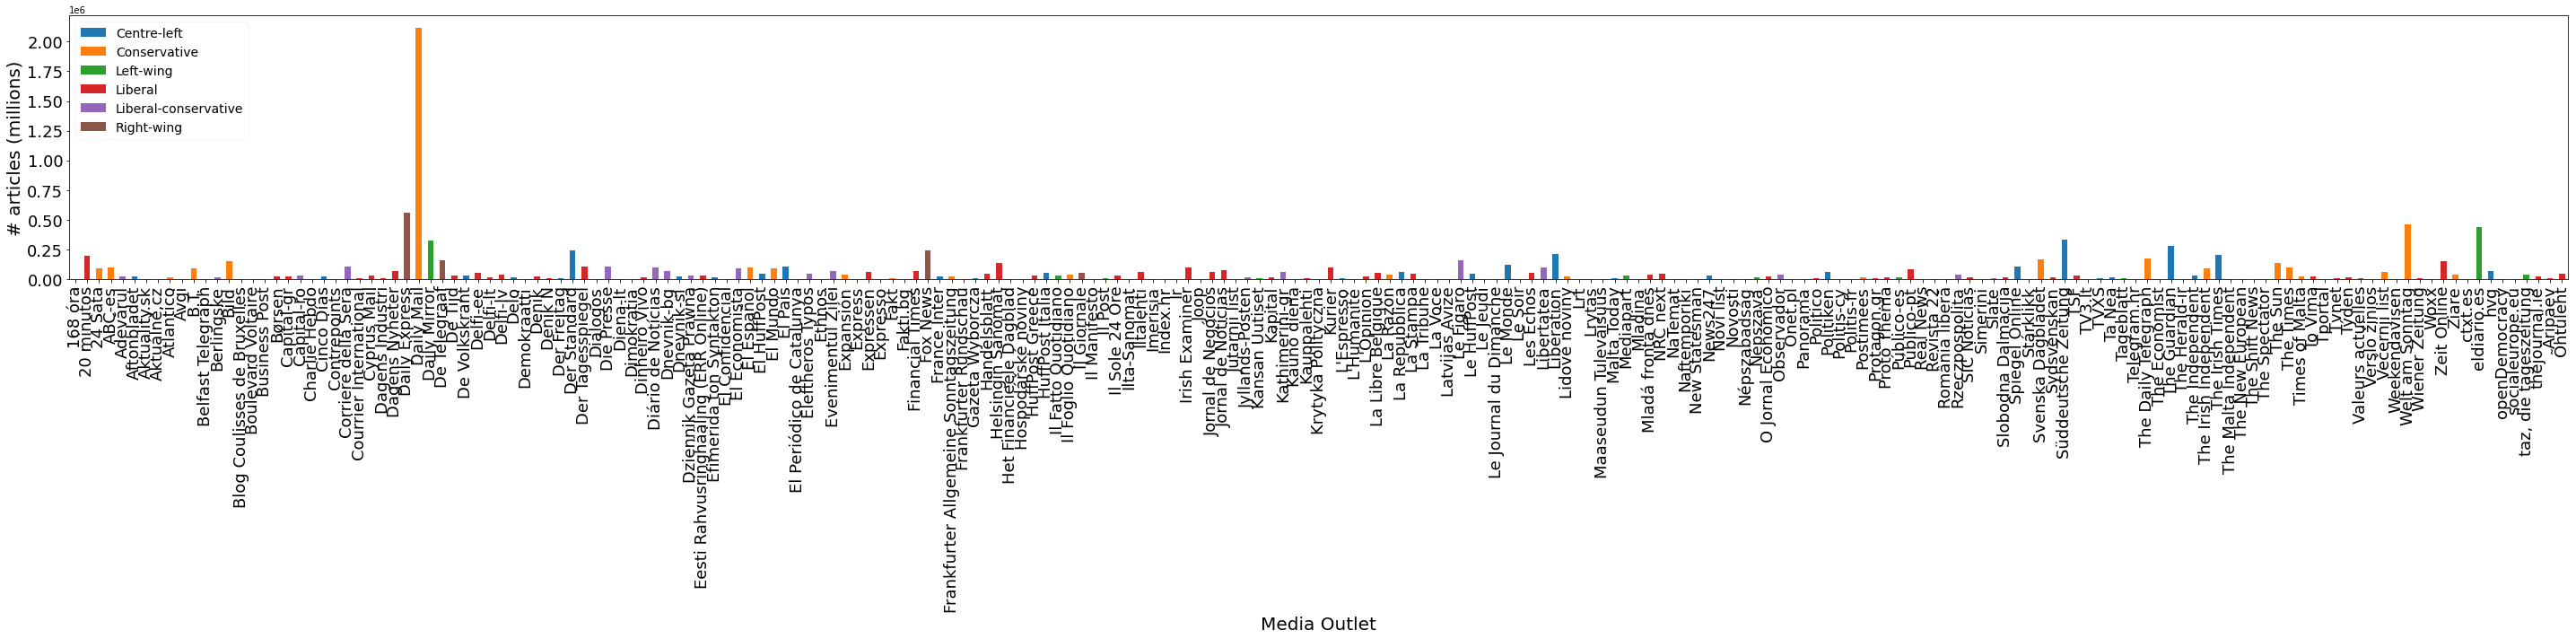

In [27]:
plot_domain_articles_distribution(all_data)

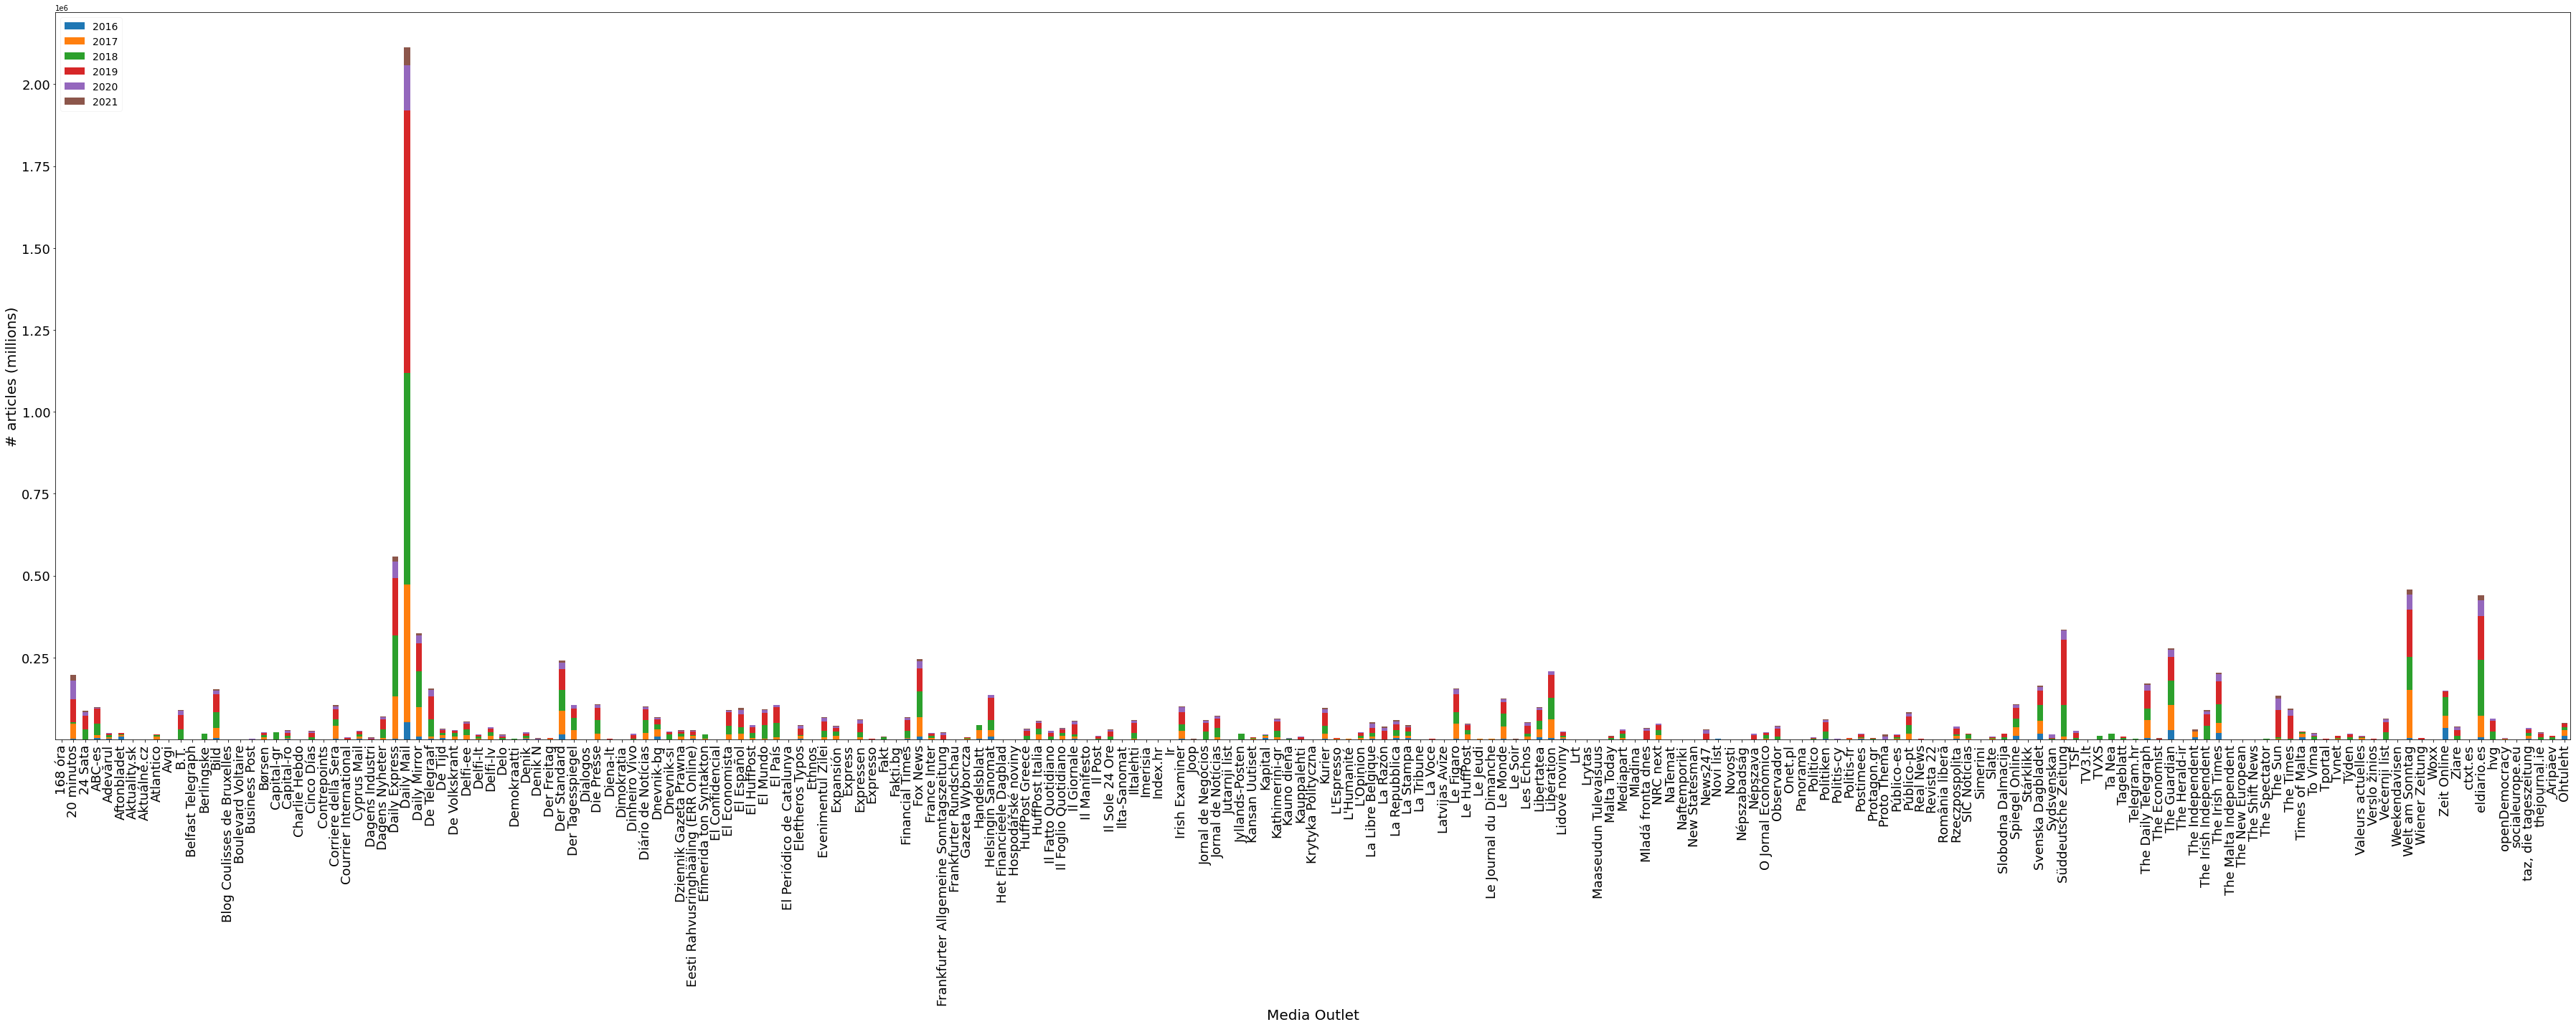

In [28]:
plot_domain_articles_year_distribution(all_data)

In [ ]:
plot_country_media_sources(all_data)

### Merging the new and the old dataset
- new: EUNewsArticles.csv
- old: all_data_eu.csv

In [5]:
# opening EUNewsArticles.csv (new dataset)
all_data = pd.read_csv('/homenfs/l.bellomo1/EUNewsArticles.csv')
new_df_ids = set(all_data.id.to_list())
print(len(new_df_ids))

In [7]:
# saving ids of EUNewsArticles.csv
new_ids = dict()
for ids in new_df_ids:
    new_ids[ids] = None
print(len(list(new_ids.keys())))
with open('/homenfs/l.bellomo1/BiasClassification/data/new_ids.csv', 'w') as fp:
    json.dump(new_ids, fp)

with open('/homenfs/l.bellomo1/BiasClassification/data/new_ids.csv') as json_file:
    new_ids = json.load(json_file)

11692352


In [ ]:
# Opening all_data_eu.csv (old dataset)
old_data = pd.read_csv('/homenfs/l.bellomo1/BiasClassification/data/all_data_eu.csv')
old_data_ids = set(old_data.id.to_list())
print(len(old_data_ids))

In [9]:
# saving ids of all_data_eu.csv
old_ids = dict()
for ids in old_data_ids:
    old_ids[ids] = None
print(len(list(old_ids.keys())))
with open('/homenfs/l.bellomo1/BiasClassification/data/old_ids.csv', 'w') as fp:
    json.dump(old_ids, fp)

with open('/homenfs/l.bellomo1/BiasClassification/data/old_ids.csv') as json_file:
    old_ids = json.load(json_file)

15665795


In [26]:
# Compute the symmetric difference and the intersection between the two datasets
symm = {k: new_ids.get(k, old_ids.get(k)) for k in new_ids.keys() ^ old_ids}
print('simmetric difference:', len(symm))
setA = set(old_ids)
setB = set(new_ids)
intersect = setA.intersection(setB)
print('intersection:', len(intersect))  

simmetric difference: 12089781
intersection: 7634183


In [27]:
included = 0
excluded = 0
excluded_ids = dict()
included_ids = list()
for ids in old_ids:
    if ids in new_ids:
        included+=1
        included_ids.append(ids)
    else:
        excluded+=1
        excluded_ids[ids] = None
print('# articles in the intersection between all_data_eu.csv and EUNewsArticles.csv', included)
print('# articles contained in all_data_eu.csv that are not in EUNewsArticles.csv', excluded)

# articles in the intersection between all_data_eu.csv and EUNewsArticles.csv 7634183
# articles contained in all_data_eu.csv that are not in EUNewsArticles.csv 8031612


#### Dataset that contains all articles contained in **all_data_eu.csv** that are not **in EUNewsArticles.csv** 
- dobbiamo trovare gli url di questi articoli e unire i due dataset

In [16]:
to_find = pd.read_csv('/homenfs/l.bellomo1/BiasClassification/data/eudata_without_url.csv')

In [18]:
record_to_find = to_find.set_index(['title','id'])['source_domain'].to_dict()

In [28]:
pd.set_option('display.max_colwidth', None)

In [29]:
to_find.head()

,title,maintext,date_publish,language,source_domain,id,date,year,source_name,political_leaning,country
0,Baustelle Pilgramgasse: Die Neuordnung des Wiener Untergrunds,"""Solche Arbeiten versuchen wir natürlich untertags zu machen"", ruft Martin Jatzko und steigt die Stiegen in Richtung Gleise hinab. Ein riesiges Bohrgerät liefert die Erklärung dafür, was er meint.\nDröhnend und hämmernd bahnt sich die Maschine neben dem Otto-Wagner-Gebäude an der Pilgrambrücke ihren Weg in die Erde.",2019-02-15 04:00:00,de,www.kurier.at,aa41faf73c778b536e4f2593a37d7c25eaaf39c2878868393f1f66958c2804a7.json,2019-02-15 04:00:00,2019.0,Kurier,Liberal,Austria
1,Der Fernsehwahlkampf der Emotionen ist vorbei,"Die letzten Video-Lücken sind abgedichtet: Kleine Fernsehsender, Medienhäuser, die früher ausschließlich Papier bedruckten, Internetplattformen – noch nie gab es so viele Bewegtbilder von Politikern in einem Nationalratswahlkampf. 42 Stunden TV-Live-Wahlkampf binnen acht Wochen auf sämtlichen heimischen Fernsehstationen sorgten für steten Nachschub an reihenweisen wechselseitigen Vorwürfen, Abgrenzungen und Reibereien.\nSoviel Fernsehen war noch nie – und die Masse der Debatten spülte Einzelthemen regelrecht weg.",2019-09-27 14:55:55,de,www.kurier.at,2f209f932ecb28e8919125312577376e9b3a1458b19c924051e1c24531f0ea7a.json,2019-09-27 14:55:55,2019.0,Kurier,Liberal,Austria
2,Luxus und Prestige: Was dürfen sich Politiker leisten?,"„Das Schnitzel“, postet SPÖ-Chefin Pamela Rendi-Wagner auf Twitter, „darf nicht zum Luxus werden.“\nWenig später wird sie im Urlaub im noblen „Le Club 55“ an der französischen Côte d’Azur gesichtet – und fotografiert. Das Bild landet in eben jenen sozialen Netzwerken, derer sich Rendi-Wagner noch kurz zuvor selbst bedient hat.\nEin „Luxusclub“, schreiben Boulevardmedien wenig später. Das „berühmteste Strandlokal der Welt“, nannte es die seriösere Frankfurter Allgemeine einst. Ein Steak kostet im „Le Club 55“ zwischen 30 und 40 Euro. Zumindest, wenn man Speisekarten Glauben schenkt, die im Internet kursieren. Das ist nicht die Welt. Und nicht mehr als in manchem Wiener Innenstadtlokal.",2019-08-12 16:12:33,de,www.kurier.at,4db9af3f43ade34a6c6608bb912ad7405b9bc2641d6ff6cc0e256eaa758fb1b7.json,2019-08-12 16:12:33,2019.0,Kurier,Liberal,Austria
3,Dieses Festival werden Kaffee-Junkies lieben,"Das richtige Wasser, die richtige Maschine, die richtigen Kaffeebohnen und das richtige Handwerk – für die Zubereitung des perfekten Kaffees brauchen Hobby-Baristas ein umfangreiches Wissen. Kommenden Freitag, Samstag und Sonntag findet zum vierten Mal das Vienna Coffee Festival statt: In der Ottakringer Brauerei können sich Kaffee-Aficionados über die neuesten Trends informieren und Spezialitäten verkosten. Neben heimischen Mikroröstern stellen auch Traditionsröster wie Julius Meinl ihre Spezialitäten vor.\nFoto: Christina_Karagiannis Die Wiener Bar-Szene zeigt den Festival-Besuchern, wie die neuesten Cocktail-Kreationen mit Kaffee gelingen. Außerdem messen sich Kaffeeröster um die Meistertitel im Barista Wettbewerb oder der Latte Art. Bei Letzterem wird nicht mit Bleistift und Papier, sondern mit Espresso und Milchschaum gezeichnet. Um Farbe ins Spiel zu bringen, ist auch Lebensmittelfarbe erlaubt.\nMit Bowls, Currys, frischen Croissants und Burgern ist der kulinarische Part abgedeckt. Ob Kaffeeröstung oder Porzellan-Filter, vor Ort können Besucher alle Utensilien für den Genuss zu Hause erwerben.\nInfo: Vienna Coffee Festival, Ottakringer Platz 1, 1160 Wien, 12. bis 14. Jänner 2018 (Freitag 10 bis 14 Uhr, ausschließlich Industrie, Handel, für Publikum am Freitag 14 bis 20 Uhr, Samstag 10 bis 20 Uhr, Sonntag 10 bis 18 Uhr), Vorverkauf: Tagesticket 10 Euro, Tageskassa: Tagesticket 12 Euro, freier Eintritt für Kinder bis 16 Jahre",2018-01-10 13:41:31,de,www.kurier.at,c0c95820643076829e69dd38e8ed0d6edccfa67d0db55608abb382dae99478df.json,2018-01-10 13:41:31,2018.0,Kurier,Liberal,Austria
4,Flüchtlinge: NGO-Schiff erhält keine Lande-Genehmigung,"

In [16]:
import requests
import urllib
import pandas as pd
from requests_html import HTML
from requests_html import HTMLSession

def get_source(url):
    """Return the source code for the provided URL. 

    Args: 
        url (string): URL of the page to scrape.

    Returns:
        response (object): HTTP response object from requests_html. 
    """

    try:
        session = HTMLSession()
        response = session.get(url)
        return response

    except requests.exceptions.RequestException as e:
        print(e)

In [17]:
def scrape_google(query):

    query = urllib.parse.quote_plus(query)
    response = get_source("https://www.google.co.uk/search?q=" + query)

    links = list(response.html.absolute_links)
    google_domains = ('https://www.google.', 
                      'https://google.', 
                      'https://webcache.googleusercontent.', 
                      'http://webcache.googleusercontent.', 
                      'https://policies.google.',
                      'https://support.google.',
                      'https://maps.google.')

    for url in links[:]:
        if url.startswith(google_domains):
            links.remove(url)
    
    return links

In [18]:

scrape_google("Flüchtlinge: NGO-Schiff erhält keine Lande-Genehmigung")

['https://m.facebook.com/ZDFheute/photos/10156588771775680',
 'https://de.wikipedia.org/wiki/Open_Arms',
 'https://translate.google.co.uk/translate?hl=it&sl=de&u=https://m.facebook.com/ZDFheute/photos/10156588771775680&prev=search&pto=aue',
 'https://newstral.com/de/article/de/1071707121/fl%C3%BCchtlinge-ngo-schiff-vor-italien-zu-kontrolle-gestoppt',
 'https://www.sonntagsblatt.de/artikel/alan-kurdi-seenotrettung-newsticker-aktuelles',
 'https://translate.google.co.uk/translate?hl=it&sl=de&u=https://newstral.com/de/article/de/1071707121/fl%25C3%25BCchtlinge-ngo-schiff-vor-italien-zu-kontrolle-gestoppt&prev=search&pto=aue',
 'https://translate.google.co.uk/translate?hl=it&sl=de&u=https://www.addendum.org/seenotrettung/nothafenrecht/&prev=search&pto=aue',
 'https://www.addendum.org/seenotrettung/nothafenrecht/',
 'https://translate.google.co.uk/translate?hl=it&sl=de&u=https://www.sueddeutsche.de/projekte/artikel/politik/seenotrettung-im-mittelmeer-2020-die-bilanz-e670960/&prev=search&pto

In [65]:
from googlesearch import search   

def make_google_query(query,domain):

    links = []
    res = []
    for j in search(query, tld="co.in", num=3, stop=3, pause=1): 
        links.append(j) 
    for i in range(len(links)): 
        if domain.replace('www.','') in links[i]: 
            res = links[i]
            break

    return res

In [66]:
#to_find = pd.read_csv('/homenfs/l.bellomo1/BiasClassification/data/eudata_without_url.csv')
#record_to_find = to_find.set_index('title')['source_domain'].to_dict()
results = dict()
for query,domain in record_to_find.items():

    print(query[0], query[1], domain)
    res = make_google_query(query[0],domain)
    print(res)
    if res:
        results[query] = res.replace('https://','')
    else:
        results[query] = None

Baustelle Pilgramgasse: Die Neuordnung des Wiener Untergrunds aa41faf73c778b536e4f2593a37d7c25eaaf39c2878868393f1f66958c2804a7.json www.kurier.at
https://kurier.at/chronik/wien/baustelle-pilgramgasse-die-neuordnung-des-wiener-untergrunds/400407998
Der Fernsehwahlkampf der Emotionen ist vorbei 2f209f932ecb28e8919125312577376e9b3a1458b19c924051e1c24531f0ea7a.json www.kurier.at
[]
Luxus und Prestige: Was dürfen sich Politiker leisten? 4db9af3f43ade34a6c6608bb912ad7405b9bc2641d6ff6cc0e256eaa758fb1b7.json www.kurier.at
https://kurier.at/politik/inland/luxus-und-prestige-was-duerfen-sich-politiker-leisten/400576514
Dieses Festival werden Kaffee-Junkies lieben c0c95820643076829e69dd38e8ed0d6edccfa67d0db55608abb382dae99478df.json www.kurier.at
https://kurier.at/genuss/dieses-festival-werden-kaffee-junkies-lieben/305.837.976
Flüchtlinge: NGO-Schiff erhält keine Lande-Genehmigung f15aa52c39345794c73443493713070c8a47a6f68294bb74ca01dc73ed058945.json www.kurier.at
https://kurier.at/politik/ausland

In [54]:
results

{('Baustelle Pilgramgasse: Die Neuordnung des Wiener Untergrunds',
  'aa41faf73c778b536e4f2593a37d7c25eaaf39c2878868393f1f66958c2804a7.json'): 'kurier.at/chronik/wien/baustelle-pilgramgasse-die-neuordnung-des-wiener-untergrunds/400407998'}

In [24]:
to_find.head()

,title,maintext,date_publish,language,source_domain,id,date,year,source_name,political_leaning,country
0,Baustelle Pilgramgasse: Die Neuordnung des Wie...,"""Solche Arbeiten versuchen wir natürlich unter...",2019-02-15 04:00:00,de,www.kurier.at,aa41faf73c778b536e4f2593a37d7c25eaaf39c2878868...,2019-02-15 04:00:00,2019.0,Kurier,Liberal,Austria
1,Der Fernsehwahlkampf der Emotionen ist vorbei,Die letzten Video-Lücken sind abgedichtet: Kle...,2019-09-27 14:55:55,de,www.kurier.at,2f209f932ecb28e8919125312577376e9b3a1458b19c92...,2019-09-27 14:55:55,2019.0,Kurier,Liberal,Austria
2,Luxus und Prestige: Was dürfen sich Politiker ...,"„Das Schnitzel“, postet SPÖ-Chefin Pamela Rend...",2019-08-12 16:12:33,de,www.kurier.at,4db9af3f43ade34a6c6608bb912ad7405b9bc2641d6ff6...,2019-08-12 16:12:33,2019.0,Kurier,Liberal,Austria
3,Dieses Festival werden Kaffee-Junkies lieben,"Das richtige Wasser, die richtige Maschine, di...",2018-01-10 13:41:31,de,www.kurier.at,c0c95820643076829e69dd38e8ed0d6edccfa67d0db556...,2018-01-10 13:41:31,2018.0,Kurier,Liberal,Austria
4,Flüchtlinge: NGO-Schiff erhält keine Lande-Gen...,"Die spanische NGO ""Proactiva Open Arms"", die a...",2018-03-16 15:27:27,de,www.kurier.at,f15aa52c39345794c73443493713070c8a47a6f68294bb...,2018-03-16 15:27:27,2018.0,Kurier,Liberal,Austria
